In [51]:
import numpy as np
import matplotlib.pyplot as plt
import random
import pylab as py

## Campo de um dipolo

In [52]:
#criando grid. Atemporal
xmin = -3000
xmax = 3000
nx = 200

ymin = -3000
ymax = 3000
ny = 200

x = np.linspace(xmin, xmax, nx, endpoint=True) # metros
y = np.linspace(ymin, ymax, ny, endpoint=True) # metros
z = -10.0 # metros
X,Y = np.meshgrid(x,y)

In [53]:
def dipolo_bx(x, y, z, sphere, mag, incs, decs):
    '''    
    It is a Python implementation for a Fortran subroutine contained in Blakely (1995). 
    It computes the X component of the magnetic induction caused by a sphere with uniform  
    distribution of magnetization. The direction X and Y represents the north and east, Z 
    represents growth downward. This function receives the coordinates of the points of 
    observation (X, Y, Z - arrays), the coordinates of the center of the sphere (Xe, Ye, Ze), 
    the magnetization intensity M and the values for inclination and declination (in degrees). 
    The observation values are given in meters.
    
    Inputs: 
    x, y, z - numpy arrays - position of the observation points
    sphere[0, 1, 2] - arrays - position of the center of the sphere
    sphere[3] - float - value for the spehre radius  
    sphere[4] - flaot - magnetization intensity value
    direction - numpy array - inclination and declination values
    
    Outputs:
    Bx - induced field on X direction
     
    Ps. The value for Z can be a scalar in the case of one depth, otherwise it can 
    be a set of points.    
    '''
    
    # Stablishing some conditions
    #if x.shape != y.shape:
        #raise ValueError("All inputs must have same shape!")
    
    # Calculates some constants
    t2nt = 1.e9 # Testa to nT - conversion
    cm = 1.e-7  # Magnetization constant
    
    #Setting some constants
    xe, ye, ze = sphere[0], sphere[1], sphere[2]
    radius = sphere[3]
    
    # Distances in all axis directions - x, y e z
    rx = x - xe
    ry = y - ye
    rz = z - ze
    
    # Computes the distance (r) as the module of the other three components
    r2 = rx**2 + ry**2 + rz**2
        
    # Computes the magnetization values for all directions
    mx, my, mz = dircos(incs, decs)
    
    # Auxiliar calculation
    dot = rx*mx + ry*my + rz*mz  # Scalar product
    m = (4.*np.pi*(radius**3)*mag)/3.    # Magnetic moment
    
    # Component calculation - Bx
    bx = m*(3.*dot*rx - (r2*mx))/(r2**(2.5))

    # Final component calculation
    bx *= cm*t2nt
    
    # Return the final output
    return bx

def dipolo_by(x, y, z, sphere, mag, incs, decs):

    '''    
    It is a Python implementation for a Fortran subroutine contained in Blakely (1995). It 
    computes the Y component of the magnetic induction caused by a sphere with uniform  
    distribution of magnetization. The direction X represents the north and Z represents 
    growth downward. This function receives the coordinates of the points of observation 
    (X, Y, Z - arrays), the coordinates of the center  of the sphere (Xe, Ye, Ze), the 
    magnetization intensity M and the values for inclination and declination (in degrees). 
    The observation values are given in meters.
    
    Inputs: 
    x, y, z - numpy arrays - position of the observation points
    sphere[0, 1, 2] - arrays - position of the center of the sphere
    sphere[3] - float - value for the spehre radius  
    sphere[4] - flaot - magnetization intensity value
    direction - numpy array - inclination, declination values
    
    Outputs:
    By - induced field on Y direction
     
    Ps. The value for Z can be a scalar in the case of one depth, otherwise it can be a 
    set of points.    
    '''
    
    # Stablishing some conditions
    #if x.shape != y.shape:
        #raise ValueError("All inputs must have same shape!")
        
    # Calculates some constants
    t2nt = 1.e9 # Testa to nT - conversion
    cm = 1.e-7  # Magnetization constant

    #Setting some constants
    xe, ye, ze = sphere[0], sphere[1], sphere[2]
    radius = sphere[3]
    
    # Distances in all axis directions - x, y e z
    rx = x - xe
    ry = y - ye
    rz = z - ze
    
    # Computes the distance (r) as the module of the other three components
    r2 = rx**2 + ry**2 + rz**2
        
    # Computes the magnetization values for all directions
    mx, my, mz = dircos(incs, decs)
    
    # Auxiliars calculations
    dot = rx*mx + ry*my + rz*mz  # Scalar product
    m = (4.*np.pi*(radius**3)*mag)/3.    # Magnetic moment
    
    # Component calculation - By
    by = m*(3.*dot*ry - (r2*my))/(r2**(2.5))
    
    # Final component calculation
    by *= cm*t2nt
    
    # Return the final output
    return by

def dipolo_bz(x, y, z, sphere, mag, incs, decs):

    '''    
    It is a Python implementation for a Fortran subroutine contained in Blakely (1995). It 
    computes the Z component of the magnetic induction caused by a sphere with uniform  
    distribution of magnetization. The direction X represents the north and Z represents 
    growth downward. This function receives the coordinates of the points of observation 
    (X, Y, Z - arrays), the coordinates of the center of the sphere (Xe, Ye, Ze), the
    magnetization intensity M and the values for inclination and declination (in degrees). 
    The observation values are given in meters.
    
    Inputs: 
    x, y, z - numpy arrays - position of the observation points
    sphere[0, 1, 2] - arrays - position of the center of the sphere
    sphere[3] - float - value for the spehre radius  
    sphere[4] - flaot - magnetization intensity value
    direction - numpy array - inclination and declination values
    
    Outputs:
    Bz - induced field on Z direction
     
    Ps. The value for Z can be a scalar in the case of one depth, otherwise it can be a 
    set of points.
    '''
    
    # Stablishing some conditions
    #if x.shape != y.shape:
        #raise ValueError("All inputs must have same shape!")
    
    # Calculates some constants
    t2nt = 1.e9 # Testa to nT - conversion
    cm = 1.e-7  # Magnetization constant
    
    #Setting some constants
    xe, ye, ze = sphere[0], sphere[1], sphere[2]
    radius = sphere[3]
    
    # Distances in all axis directions - x, y e z
    rx = x - xe
    ry = y - ye
    rz = z - ze
    
    # Computes the distance (r) as the module of the other three components
    r2 = rx**2 + ry**2 + rz**2
    
    # Computes the magnetization values for all directions
    mx, my, mz = dircos(incs, decs)
    
    # Auxiliars calculations
    dot = (rx*mx) + (ry*my) + (rz*mz)  # Scalar product
    m = (4.*np.pi*(radius**3)*mag)/3.    # Magnetic moment
    
    # Component calculation - Bz
    bz = m*(3.*dot*rz - (r2*mz))/(r2**(2.5))

    # Final component calculation
    bz *= cm*t2nt
    
    # Return the final output
    return bz

def dircos(inc, dec, azm = 0.):
    '''
    This function calculates the cossines projected values on directions using inclination 
    and declination values. Here, we do not considerate an azimuth as a zero value, but as 
    an input value.    
    
    Inputs:
    theta_inc - inclination angle
    theta_dec - declination angle 
    Outputs:
    dirA - projected cossine A
    dirB - projected cossine B
    dirC - projected cossine C    
    '''
    
    # Use the function to convert some values
    incl = np.deg2rad(inc)
    decl = np.deg2rad(dec)
    azim = np.deg2rad(azm)
    # Calculates the projected cossine values
    A = np.cos(incl)*np.cos(decl - azim)
    B = np.cos(incl)*np.sin(decl - azim)
    C = np.sin(incl)
    
    # Return the final output
    return A, B, C

def F_regional(intensity, incf, decf):
    '''
    This fucntion computes the projected components of the regional magnetic field in all 
    directions X, Y and Z. This calculation is done by using a cossine projected function, 
    which recieves the values for an inclination, declination and also and azimuth value. 
    It returns all three components for a magnetic field (Fx, Fy e Fz), using a value for 
    the regional field (F) as a reference for the calculation.
    
    Inputs: 
    field - numpy array
        intensity - float - regional magnetic intensity
        incF - float - magnetic field inclination value
        decF - float - magnetic field declination value
    Outputs:
    vecF - numpy array - F componentes along X, Y e Z axis
        
    Ps. All inputs can be arrays when they are used for a set of values.    
    '''
    
    # Computes the projected cossine
    X, Y, Z = dircos(incf, decf,)
    
    # Compute all components
    Fx, Fy, Fz = intensity*X, intensity*Y, intensity*Z
    
    # Set F as array and return the output
    return Fx, Fy, Fz

In [54]:
#campo magnético de um dipolo
#localização
xc = 330.0                                  # metros
yc = 330.0                                  # metros
zc = 800.0                                  # metros (z é positivo para baixo)
raio = 50.0                                 # metros
inc,dec = -23.0, -33.0                      # inclinacao, declinacao magnetica

bx = dipolo_bx(X,Y,z,[xc,yc,zc,raio], 2.5, inc,dec)
by = dipolo_bx(X,Y,z,[xc,yc,zc,raio], 2.5, inc,dec)
bz = dipolo_bx(X,Y,z,[xc,yc,zc,raio], 2.5, inc,dec)

# Simulação do campo Regional:
F = 23500          # nT
I,D = -25.0, -35.0 # direcao do campo do dipolo la no nucleo da terra
Fx,Fy,Fz = F_regional(F,I,D)

# Projecoes Cartesianas  o campo total (o que de fato é aferido pelo magnetometro):
Bx = bx+Fx
By = by+Fy
Bz = bz+Fz

Bt = (Bx**2 + By**2 + Bz**2)**(0.5)

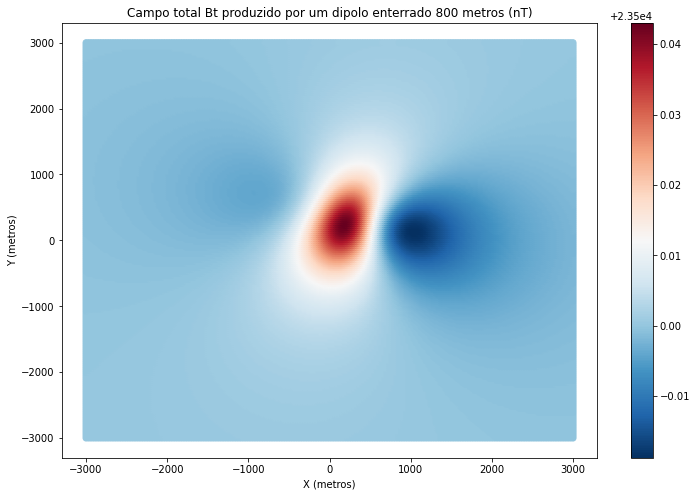

In [55]:
py.rcParams['figure.figsize'] = (12.0, 8.0) #Redimensiona a figura
plt.scatter(X,Y,c=Bt,cmap = plt.cm.RdBu_r)
plt.xlabel('X (metros)')
plt.ylabel('Y (metros)')
plt.title('Campo total Bt produzido por um dipolo enterrado %i metros (nT)'%zc)
plt.colorbar()
plt.show()

## Variação Diurna

In [56]:
F = 23500.0 # Campo regional (IGRF no Rj, por exemplo) em nT

def variacaoDiurna(h,F,vB,i=0,f=0.2):
    if 6. <= h <= 18.:
        return F + vB * np.sin((np.pi/12.0) * (h-6.0) ) + random.normalvariate(i, f)
    else:
        return F + random.normalvariate(i,f)

vB = 10                     # amplitude da variacao diurna em nT

hora = np.linspace(0.0, 24.0, 1000, endpoint=True)
B_diurno = []
for h in hora:
    B = variacaoDiurna(h,F,vB)
    B_diurno.append(B)

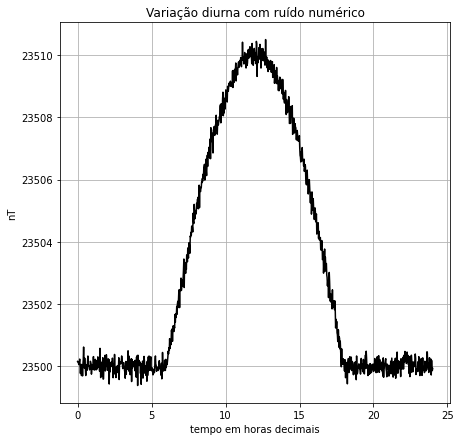

In [57]:
plt.figure(figsize=(7,7))
plt.plot(hora, B_diurno, 'k-',)
plt.xlabel('tempo em horas decimais')
plt.title("Variação diurna com ruído numérico")
plt.grid()
plt.ylabel('nT')
plt.show()

## Simulação de uma aquisição. Dados em função do tempo

In [58]:
#criando grid de observações em função do tempo
passos_x = 100
passos_y = 300

#matrizes com os dados. primeira linha é x, segunda é y, terceira é B medido e quarta é o tempo
magnetometroMovel_xyBt = [[],[],[],[]]
magnetometroBase_Bt = [[],[]]           #fixado em (0,0)

t = 6 #horas da manhã
print("Hora de início:",t)

for x in range(xmin,xmax+1,passos_x):
    for y in range(ymin,ymax+1,passos_y):
        
        t += 0.009 #espaçamento temporal entre cada ponto
        r = np.sqrt( (x-xc)**2 + (y-yc)**2 + (z-zc)**2 )
        
        B_variacao = variacaoDiurna(t,0,vB)

        #dados magnetometro movel
        bx = dipolo_bx(x,y,z,[xc,yc,zc,raio], 2.5, inc,dec)
        by = dipolo_bx(x,y,z,[xc,yc,zc,raio], 2.5, inc,dec)
        bz = dipolo_bx(x,y,z,[xc,yc,zc,raio], 2.5, inc,dec)

        Bx = bx+Fx
        By = by+Fy
        Bz = bz+Fz
        Bt = (Bx**2 + By**2 + Bz**2)**(0.5)
        
        magnetometroMovel_xyBt[0] += [x]
        magnetometroMovel_xyBt[1] += [y]
        magnetometroMovel_xyBt[2] += [Bt+B_variacao]
        magnetometroMovel_xyBt[3] += [t]
        
        #dados magnetometro base
        Bx = Fx
        By = Fy
        Bz = Fz
        Bt = (Bx**2 + By**2 + Bz**2)**(0.5)     
        
        magnetometroBase_Bt[0] += [Bt+B_variacao]
        magnetometroBase_Bt[1] += [t]        
        
    # simulando o movimento de um veiculo, então o carro faz linhas paralelas S/N "indo" e depois N/S "voltando"
    yminX = ymin
    ymin,ymax,passos_y = ymax,yminX,-passos_y
        
print("Hora de término:",t)

Hora de início: 6
Hora de término: 17.259000000000427


In [ ]:
# vizualizacao do grid de observacoes em função do tempo
py.rcParams['figure.figsize'] = (17.0, 12.0) #Redimensiona a figura

plt.subplot(2, 2, 1)
plt.scatter(magnetometroMovel_xyBt[0],magnetometroMovel_xyBt[1],c=magnetometroMovel_xyBt[2],cmap = plt.cm.RdBu_r)
plt.xlabel('X (metros)')
plt.ylabel('Y (metros)')
plt.title('Campo adquirido - Magnetómetro Móvel (nT)')
plt.colorbar()

plt.subplot(2, 2, 2)
plt.scatter(magnetometroMovel_xyBt[0],magnetometroMovel_xyBt[1],c=magnetometroMovel_xyBt[3])
plt.xlabel('X (metros)')
plt.ylabel('Y (metros)')
plt.title('Horário da aquisição dos pontos (horas decimais)')
plt.colorbar()

plt.subplot(2, 2, 3)
plt.scatter(magnetometroMovel_xyBt[0],magnetometroMovel_xyBt[1],c=magnetometroBase_Bt[0],cmap = plt.cm.RdBu_r)
plt.xlabel('X (metros)')
plt.ylabel('Y (metros)')
plt.title('Campo adquirido - Magnetómetro Base (nT)')
plt.colorbar()


plt.subplot(2, 2, 4)
plt.scatter(magnetometroMovel_xyBt[0],magnetometroMovel_xyBt[1],c=np.array(magnetometroMovel_xyBt[2])-np.array(magnetometroBase_Bt[0]),cmap = plt.cm.RdBu_r)
plt.xlabel('X (metros)')
plt.ylabel('Y (metros)')
plt.title('$B_{movel} - B_{base}$ (nT)')
plt.colorbar()

plt.savefig("image1.jpeg")

plt.show()

## Redução: Variação Diurna

> $B_{reducao} = B_{móvel} - {\Delta}L = B_{movel} - (B_{base} - B_{mediaMensal})$

> $B_{móvel} = B_{regional} + B_{dipolo}  + B_{variacaoDiurna}$

> $B_{base} = B_{regional} + B_{variacaoDiurna}$



In [ ]:
media_mensal = F
residuo = []

dadoReduzido_xyBt = np.copy(magnetometroMovel_xyBt)

dadoReduzido_xyBt[2] = magnetometroMovel_xyBt[2] - (np.array(magnetometroBase_Bt[0])-media_mensal)

for i in range(len(magnetometroMovel_xyBt[0])):
    xi = magnetometroMovel_xyBt[0][i]
    yi = magnetometroMovel_xyBt[0][i]
    
    bx = dipolo_bx(xi,yi,z,[xc,yc,zc,raio], 2.5, inc,dec)
    by = dipolo_bx(xi,yi,z,[xc,yc,zc,raio], 2.5, inc,dec)
    bz = dipolo_bx(xi,yi,z,[xc,yc,zc,raio], 2.5, inc,dec)

    Bx = bx+Fx
    By = by+Fy
    Bz = bz+Fz

    Bt = (Bx**2 + By**2 + Bz**2)**(0.5)
    
    #residuo = dadoReduzido - Bt
    residuo.append( dadoReduzido_xyBt[2][i] - Bt )

In [ ]:
# vizualizacao do grid de observacoes em função do tempo
py.rcParams['figure.figsize'] = (17.0, 4.0) #Redimensiona a figura

plt.subplot(1, 2, 1)
plt.scatter(dadoReduzido_xyBt[0],dadoReduzido_xyBt[1],c=dadoReduzido_xyBt[2],cmap = plt.cm.RdBu_r)
plt.xlabel('X (metros)')
plt.ylabel('Y (metros)')
plt.title('Redução de Variação Diurna (nT)')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.scatter(dadoReduzido_xyBt[0],dadoReduzido_xyBt[1],c=residuo,cmap = plt.cm.RdBu_r)
plt.xlabel('X (metros)')
plt.ylabel('Y (metros)')
plt.title('Resíduo (nT)')
plt.colorbar()

plt.savefig("image2.jpeg")

plt.show()